In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/end-als/end-als/genomics-data/geno_bin.csv
/kaggle/input/end-als/end-als/genomics-data/AnswerALS_subset_annovar.hg38_anno_and_geno.no_intergenic.vcf
/kaggle/input/end-als/end-als/other-data/Living with ALS - sample personas.pdf
/kaggle/input/end-als/end-als/other-data/meet_the_experts.mp4
/kaggle/input/end-als/end-als/other-data/ALS Canada blog - selected articles.pdf
/kaggle/input/end-als/end-als/other-data/Kaggle Participant List with NYGC CGND ID.csv
/kaggle/input/end-als/end-als/transcriptomics-data/L3_counts/CASE-NEUZX521TKK/CASE-NEUZX521TKK-5793-T/CASE-NEUZX521TKK-5793-T_P85.exon.txt
/kaggle/input/end-als/end-als/transcriptomics-data/L3_counts/CASE-NEUDG272XWC/CASE-NEUDG272XWC-6171-T/CASE-NEUDG272XWC-6171-T_P38.txt
/kaggle/input/end-als/end-als/transcriptomics-data/L3_counts/CASE-NEUEK191WYC/CASE-NEUEK191WYC-5842-T/CASE-NEUEK191WYC-5842-T_P92.exon.txt
/kaggle/input/end-als/end-als/transcriptomics-data/L3_counts/CTRL-NEUCV136DHM/CTRL-NEUCV136DHM-6150-T/CTRL-NEUCV136D

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.target import ClassBalance
import imblearn
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
#load and join data files on participant_id
df_ctrlvscase = pd.read_csv('/kaggle/input/end-als/end-als/transcriptomics-data/DESeq2/ctrl_vs_case.csv')

df_qc_staining = pd.read_csv('/kaggle/input/end-als/end-als/clinical-data/filtered-metadata/metadata/clinical/Answer ALS metadata datatable with QC Staining.csv')
df_qc_staining = df_qc_staining[['GUID','NEFH (SMI32)','ISL1','NKX6.1','TUBB3 (TuJ1)','s100b','Nestin']]
df_qc_staining = df_qc_staining.rename(columns = {'GUID':'Participant_ID'})

df_geno_bin = pd.read_csv('/kaggle/input/end-als/end-als/genomics-data/geno_bin.csv',index_col = [0]).T
df_geno_bin.reset_index(inplace=True)
df_geno_bin = df_geno_bin.rename(columns = {'index':'unformatted_ID'})
df_geno_bin['Participant_ID'] = df_geno_bin.unformatted_ID.apply(lambda x: x[5:])
df_geno_bin = df_geno_bin.drop(columns=['unformatted_ID'])

df_combined1 = pd.merge(df_ctrlvscase, df_qc_staining, on='Participant_ID', how='inner')
df_combined1.to_csv('/kaggle/working/stain_rna.csv')

#dataset for random forest
df_combined = pd.merge(df_combined1, df_geno_bin, on='Participant_ID')
df_combined.to_csv('/kaggle/working/stain_genomics_rna.csv')

#dataset for gwas
df_label = df_ctrlvscase[['Participant_ID','CtrlVsCase_Classifier']]
df_genome_wide = pd.merge(df_label, df_geno_bin, on='Participant_ID', how='inner')

In [4]:
def Random_Forest_Classifier(dataset,do_SMOTE,feature_idx,label_idx,ntrees):
    #fillNA, split dataset into features and labels for supervised learning
    df = dataset.fillna(0)
    
    X, y = df.iloc[:,feature_idx:],df.iloc[:,label_idx]

    #standardize the dataset for ML
    X_standard = StandardScaler().fit_transform(X)
    X = pd.DataFrame(X_standard, columns=X.columns)

    #Check the class balance
    graph = ClassBalance(labels=["class 0","class 1"])
    graph.fit(y)        
    graph.show()        

    #If the ctrl and case numbers are imbalanced the model overtrain on one class and predict all 1 for example
    #rebalance the dataset by oversampling with synthetic examples using SMOTE
    if do_SMOTE == True:
        oversample = imblearn.over_sampling.SMOTE()

        # fit and apply the transform
        X_over, y_over = oversample.fit_resample(X, y)
    else:
        X_over, y_over = X, y
        
    print('oversampled shape of X is ',X_over.shape)
    print('oversampled shape of y is ',y_over.shape,'\n')

    #save the feature names for later
    features = X_over.columns.tolist()

    #split the dataset randomly into train and test with 20% test
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=0)  

    #define a RF classifier object and fit a model
    Random_Forest = RandomForestClassifier(n_estimators=ntrees,random_state=123)
    Random_Forest.fit(X_train,y_train)

    #rank the features and store in a dataframe
    feature_importance_values = Random_Forest.feature_importances_
    feature_importances = pd.DataFrame({'feature': features, 'importance':feature_importance_values})
    
    #create a new dataframe called newX containing only features that have some predictive value
    #this is done in order to avoid overfitting (which will certainly happen with 180k features)
    key_features = feature_importances[feature_importances.importance != 0.0]
    key_features = key_features.sort_values(by='importance',ascending=False)
    key_features.to_csv('/kaggle/working/key_features_dna_rna.csv')
    key_col_names = key_features["feature"].tolist()
    newXtrain = X_train[X_train.columns.intersection(key_col_names)]
    newXtest = X_test[X_test.columns.intersection(key_col_names)]

    print('reduced dimension of training input from ', X_train.shape, 'to ', newXtrain.shape, 'by dropping irrelevant features \n')

    #plot top 20 key feature importance
    key_features.head(20).plot(kind='barh',x='feature',y='importance',color='blue')
    plt.show()

    #train a new model using the input with reduced dimensionality and make pred_final
    Random_Forest.fit(newXtrain,y_train)
    pred_temp = Random_Forest.predict(newXtest)
    pred_final = [round(value) for value in pred_temp]
    print('Check that the output prediction is not simply returning a trivial solution of all 1s \n',pred_final,'\n')
    
    # evaluate pred_final
    accuracy = accuracy_score(y_test, pred_final)
    print("Simple accuracy is: %.2f%%" % (accuracy * 100.0),'\n')
    print('ROC AUC is ', roc_auc_score(y_test, pred_final),'\n')

    explainer = shap.TreeExplainer(Random_Forest)
    shap_values = explainer.shap_values(newXtrain)
    shap.summary_plot(shap_values[1], newXtrain)

In [5]:
###Create a function to do a pseudo-GWAS and visualize the SNPs with the biggest discrepancies between classes###

def pseudo_genome_wide(dataset,label_name,feature_idx):
    features_list=dataset.columns.tolist()
    features_list = features_list[feature_idx:]
    print('checking ',len(features_list), ' SNP variations and comparing between classes\n')
    count=0
    case_lst=[]
    ctrl_lst=[]

    #calculate sample size
    total_patients = dataset.shape[0]
    case_patients = dataset.loc[dataset[label_name]>0].shape[0]
    ctrl_patients = total_patients - case_patients

    #fillna
    dataset = dataset.fillna(0)

    #check each SNP and compute the difference in frequency between classes
    for feature in features_list:
        #sum num mutations for each patient group for each feature
        var_sum = dataset.groupby(by=[label_name])[feature].sum()
        ctrl_sum = var_sum.iloc[[0]]
        case_sum = var_sum.iloc[[1]]
        case_sum = float(case_sum.values)
        ctrl_sum = float(ctrl_sum.values)
        case_pct = (case_sum / case_patients)*100
        ctrl_pct = (ctrl_sum / ctrl_patients)*100

        #save the frequency of SNP per class for plotting later
        case_lst.append(case_pct)
        ctrl_lst.append(ctrl_pct)
        
        #print progress
        count = count+1
        if count%10000 == 0:
            print('checked ', count, ' SNPs so far')
            
    #make a new dataframe for plotting and analysis
    d = {'case_pct': case_lst, 'ctrl_pct': ctrl_lst}
    df_variants = pd.DataFrame(data=d, index=features_list)
    df_variants['delta'] = df_variants['case_pct'] - df_variants['ctrl_pct']
    df_variants = df_variants.sort_values(by='delta',ascending=False)

    AX = df_variants.head(10).plot.bar(rot=0,figsize=(20,20))
    AX.set_xlabel("key variant identified by ML")
    AX.set_ylabel("Percent of participants with that variant")
    df_variants.to_csv('/kaggle/working/gwas.csv')

In [6]:
###Create a similar function but for RNA seq and compare discrepancies between classes###

def genome_wide_rna(dataset,label_name,feature_idx):
    features_list=dataset.columns.tolist()
    features_list = features_list[feature_idx:]
    print('checking ',len(features_list), ' gene expression levels and comparing between classes\n')
    count=0
    case_lst=[]
    ctrl_lst=[]

    #calculate sample size
    total_patients = dataset.shape[0]
    case_patients = dataset.loc[dataset[label_name]>0].shape[0]
    ctrl_patients = total_patients - case_patients

    #normalize data since rna value is continuous instead of binary
    df_genome_wide_rna = dataset
    df_genome_wide_rna = df_genome_wide_rna.fillna(0)
    df_genome_wide_rna = df_genome_wide_rna.drop(columns=['Participant_ID'])
    x_scaled = MinMaxScaler().fit_transform(df_genome_wide_rna)
    df_genome_wide_rna = pd.DataFrame(x_scaled, columns=df_genome_wide_rna.columns)
    
    #check each gene and compute the difference in frequency between classes
    for feature in features_list:
        #sum gene expression for each patient group for each feature
        var_sum = df_genome_wide_rna.groupby(by=[label_name])[feature].sum()
        ctrl_sum = var_sum.iloc[[0]]
        case_sum = var_sum.iloc[[1]]
        case_sum = float(case_sum.values)
        ctrl_sum = float(ctrl_sum.values)
        case_pct = (case_sum / case_patients)
        ctrl_pct = (ctrl_sum / ctrl_patients)
        #save the frequency of gene expression for plotting and analysis later
        case_lst.append(case_pct)
        ctrl_lst.append(ctrl_pct)
        
        #track progress
        count = count+1
        if count%10000 == 0:
            print('checked ', count, ' genes so far')
    
    ##make a new dataframe for plotting and analysis
    d = {'case_pct': case_lst, 'ctrl_pct': ctrl_lst}
    df_variants = pd.DataFrame(data=d, index=features_list)
    df_variants['delta'] = df_variants['case_pct'] - df_variants['ctrl_pct']
    df_variants = df_variants.sort_values(by='delta',ascending=False)

    AX = df_variants.head(10).plot.bar(rot=0,figsize=(20,20))
    AX.set_xlabel("Gene")
    AX.set_ylabel("Average relative expression of genes for top 10 differences between classes")
    #also plot which genes are not expressed by case=1 but are expressed by case=0
    df_no_expression = df_variants[(df_variants['case_pct']==0)&(df_variants['ctrl_pct']>0.07)]
    AX = df_no_expression.head(10).plot.bar(rot=0,figsize=(15,15))
    AX.set_xlabel("Gene")
    AX.set_ylabel("Average relative expression for genes not expressed by class = 1 but expressed by class =0")

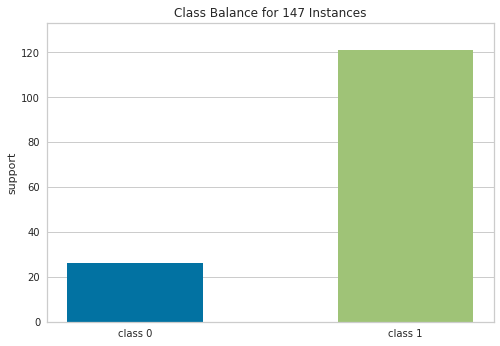

oversampled shape of X is  (242, 180678)
oversampled shape of y is  (242,) 

reduced dimension of training input from  (193, 180678) to  (193, 9470) by dropping irrelevant features 



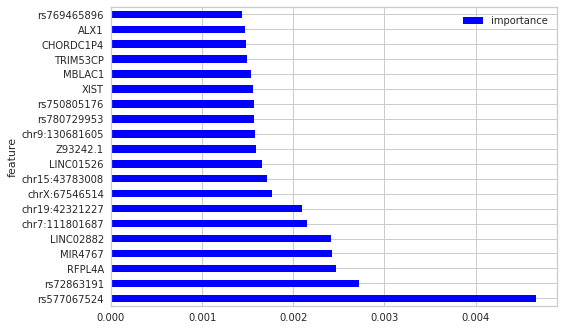

Check that the output prediction is not simply returning a trivial solution of all 1s 
 [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0] 

Simple accuracy is: 91.84% 

ROC AUC is  0.9199999999999999 



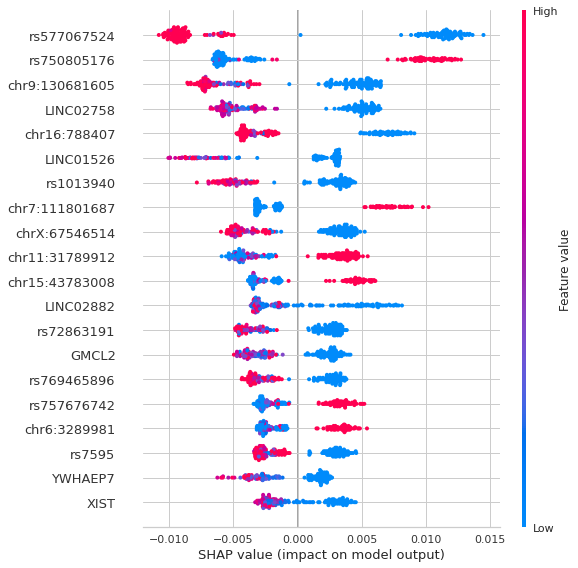

checking  126813  SNP variations and comparing between classes

checked  10000  SNPs so far
checked  20000  SNPs so far
checked  30000  SNPs so far
checked  40000  SNPs so far
checked  50000  SNPs so far
checked  60000  SNPs so far
checked  70000  SNPs so far
checked  80000  SNPs so far
checked  90000  SNPs so far
checked  100000  SNPs so far
checked  110000  SNPs so far
checked  120000  SNPs so far
checking  53859  gene expression levels and comparing between classes

checked  10000  genes so far
checked  20000  genes so far
checked  30000  genes so far
checked  40000  genes so far
checked  50000  genes so far


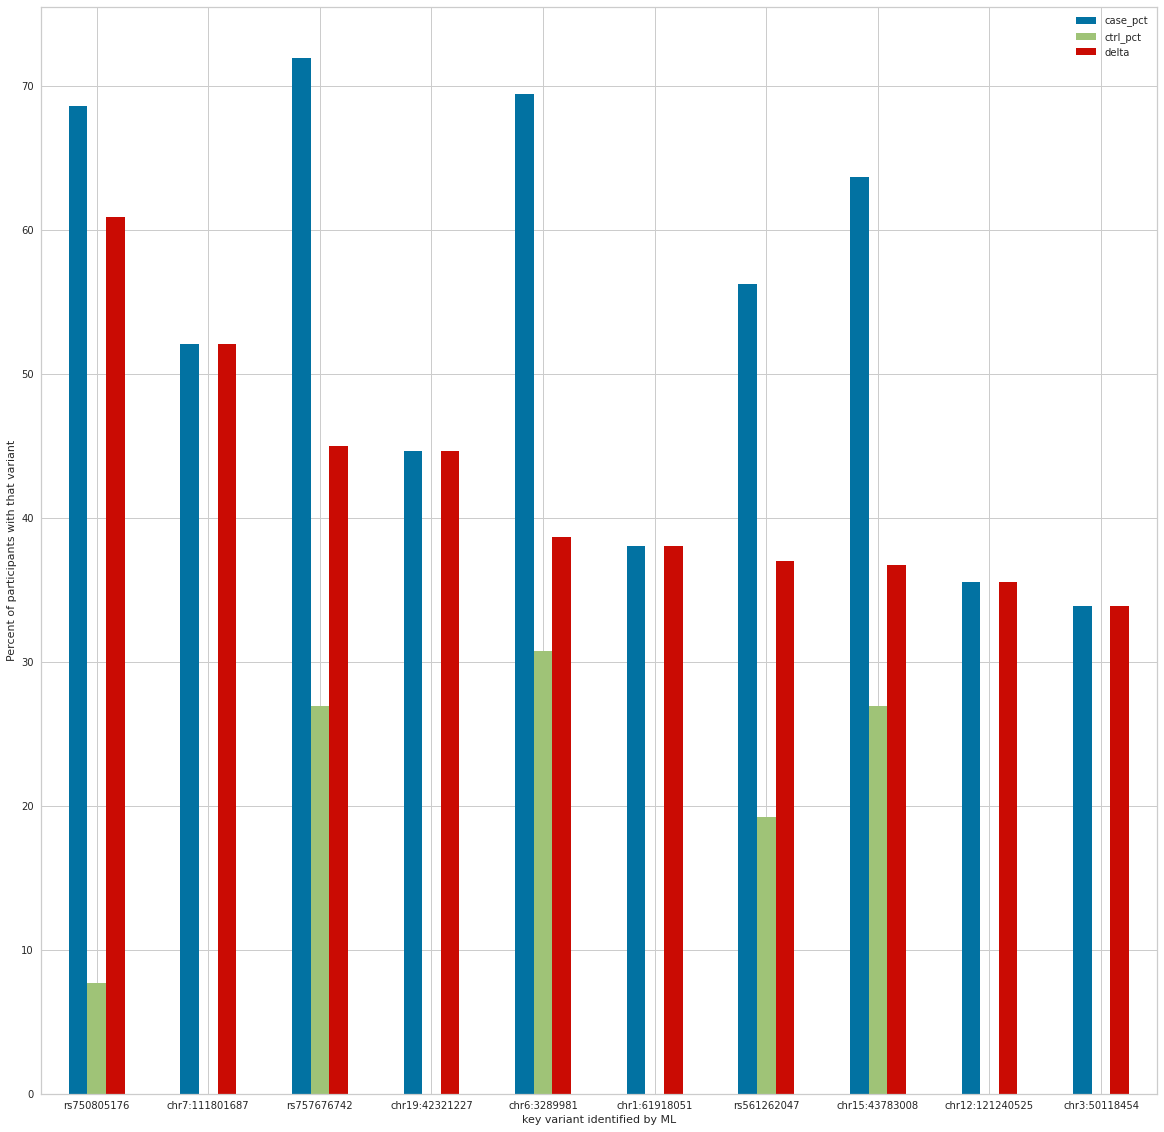

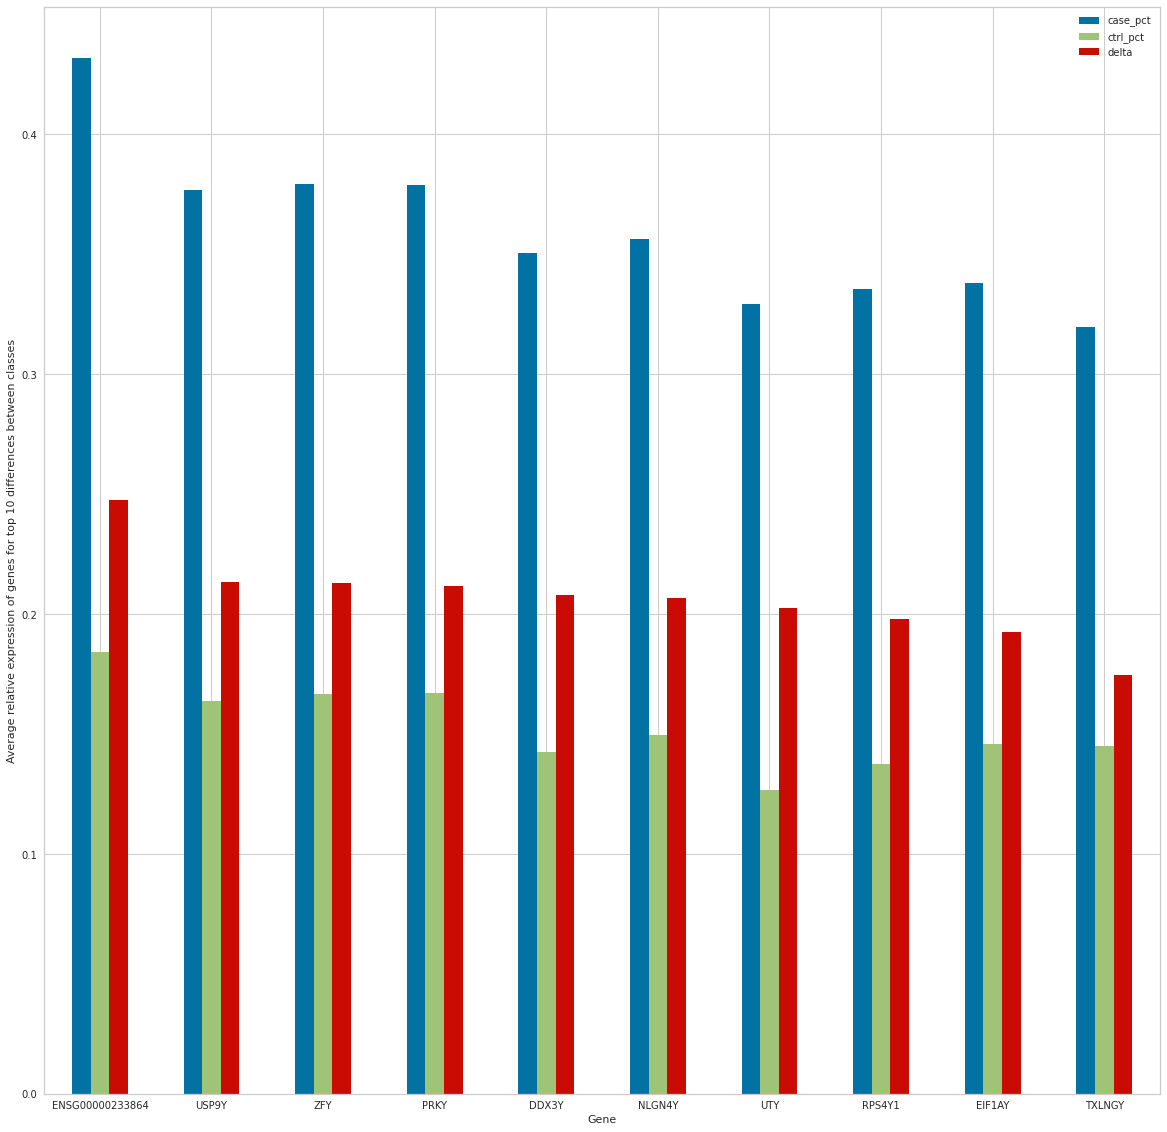

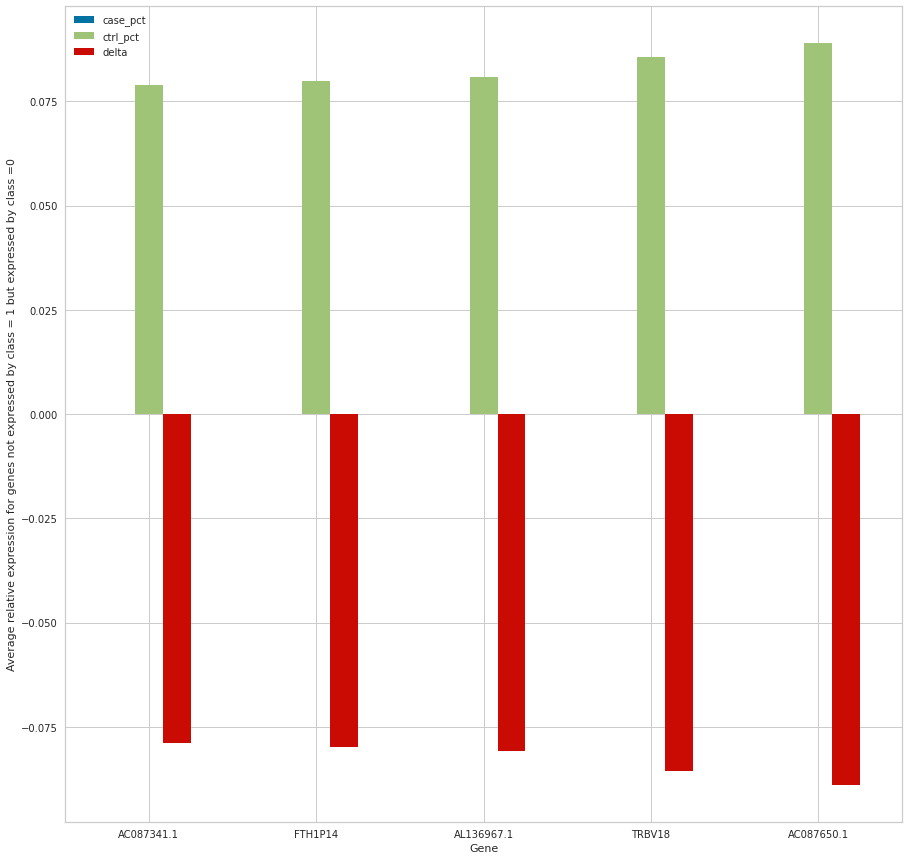

In [7]:
#step 1a - run the random forest classifier
Random_Forest_Classifier(dataset=df_combined,do_SMOTE=True,feature_idx=2,label_idx=1,ntrees=1000)

#step 1b - run the pseudo-gwas
pseudo_genome_wide(dataset=df_genome_wide,label_name = 'CtrlVsCase_Classifier',feature_idx = 2)

#step 1c - run the rna comparison function
genome_wide_rna(dataset=df_ctrlvscase,label_name = 'CtrlVsCase_Classifier',feature_idx = 2)

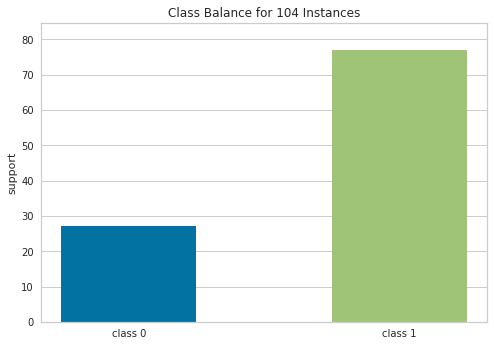

oversampled shape of X is  (154, 180672)
oversampled shape of y is  (154,) 

reduced dimension of training input from  (123, 180672) to  (123, 7667) by dropping irrelevant features 



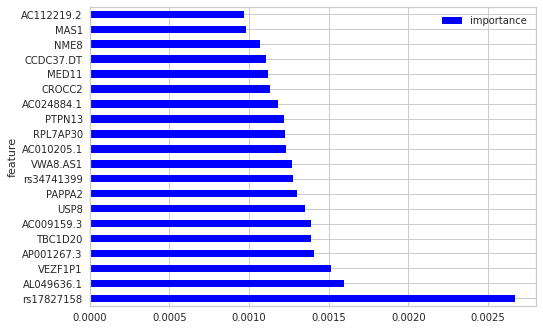

Check that the output prediction is not simply returning a trivial solution of all 1s 
 [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0] 

Simple accuracy is: 90.32% 

ROC AUC is  0.90625 



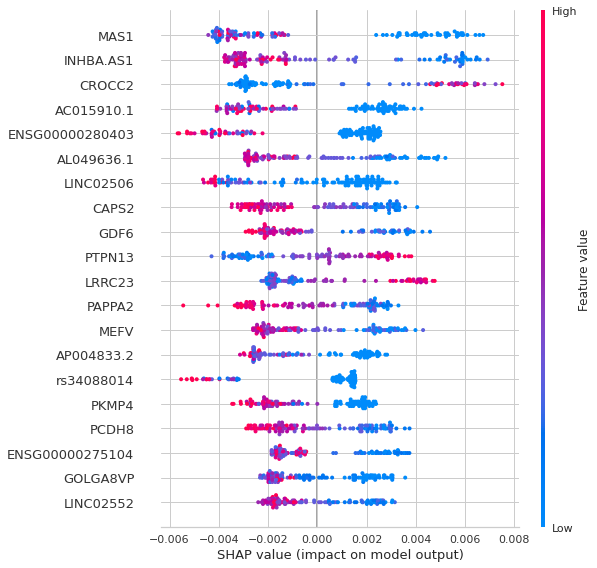

checking  126813  SNP variations and comparing between classes

checked  10000  SNPs so far
checked  20000  SNPs so far
checked  30000  SNPs so far
checked  40000  SNPs so far
checked  50000  SNPs so far
checked  60000  SNPs so far
checked  70000  SNPs so far
checked  80000  SNPs so far
checked  90000  SNPs so far
checked  100000  SNPs so far
checked  110000  SNPs so far
checked  120000  SNPs so far
checking  53859  gene expression levels and comparing between classes

checked  10000  genes so far
checked  20000  genes so far
checked  30000  genes so far
checked  40000  genes so far
checked  50000  genes so far


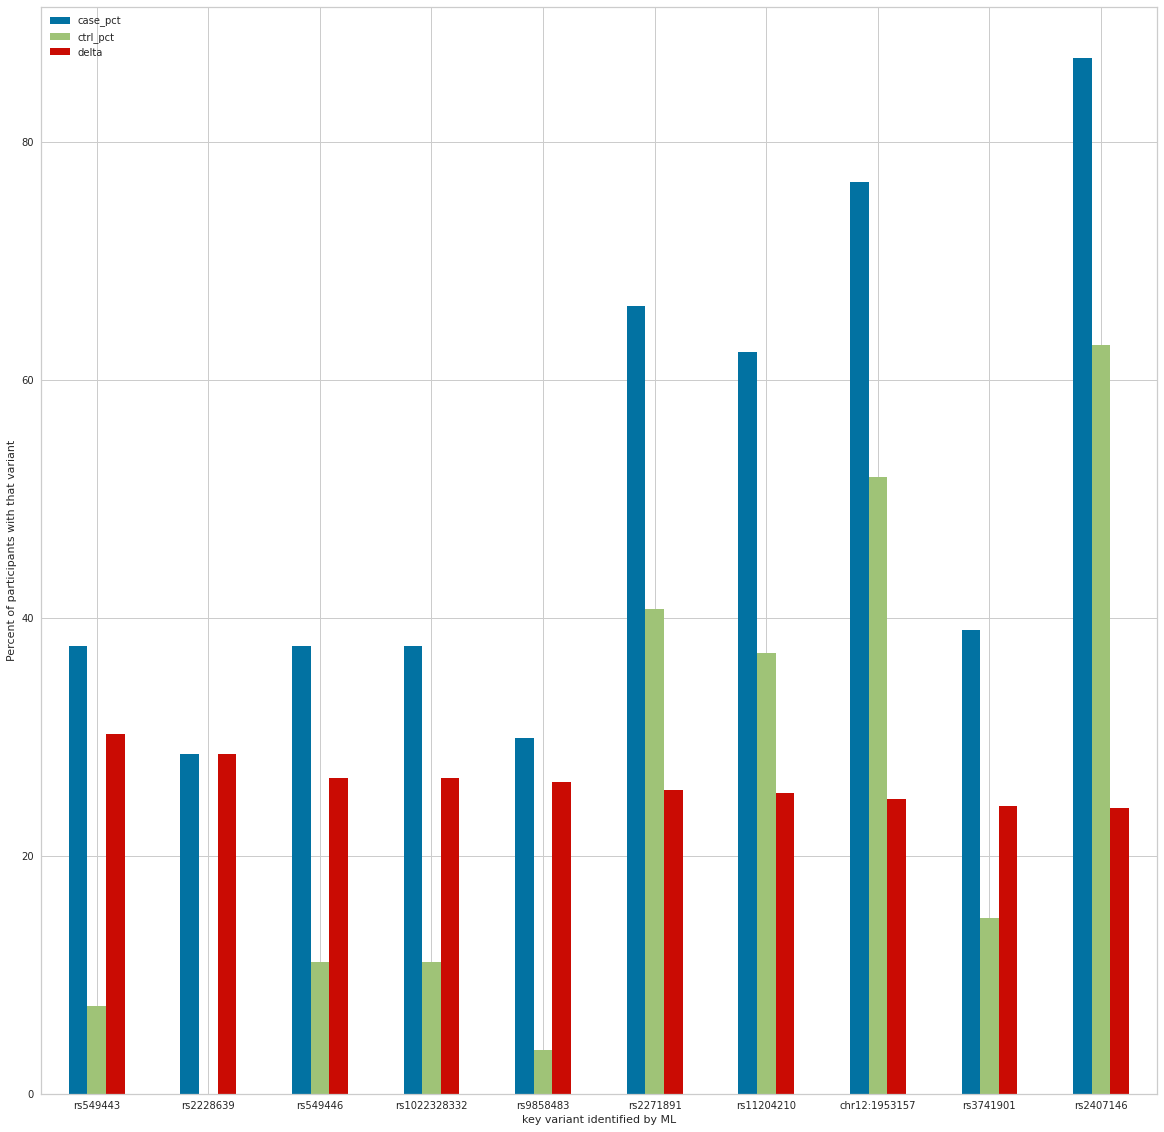

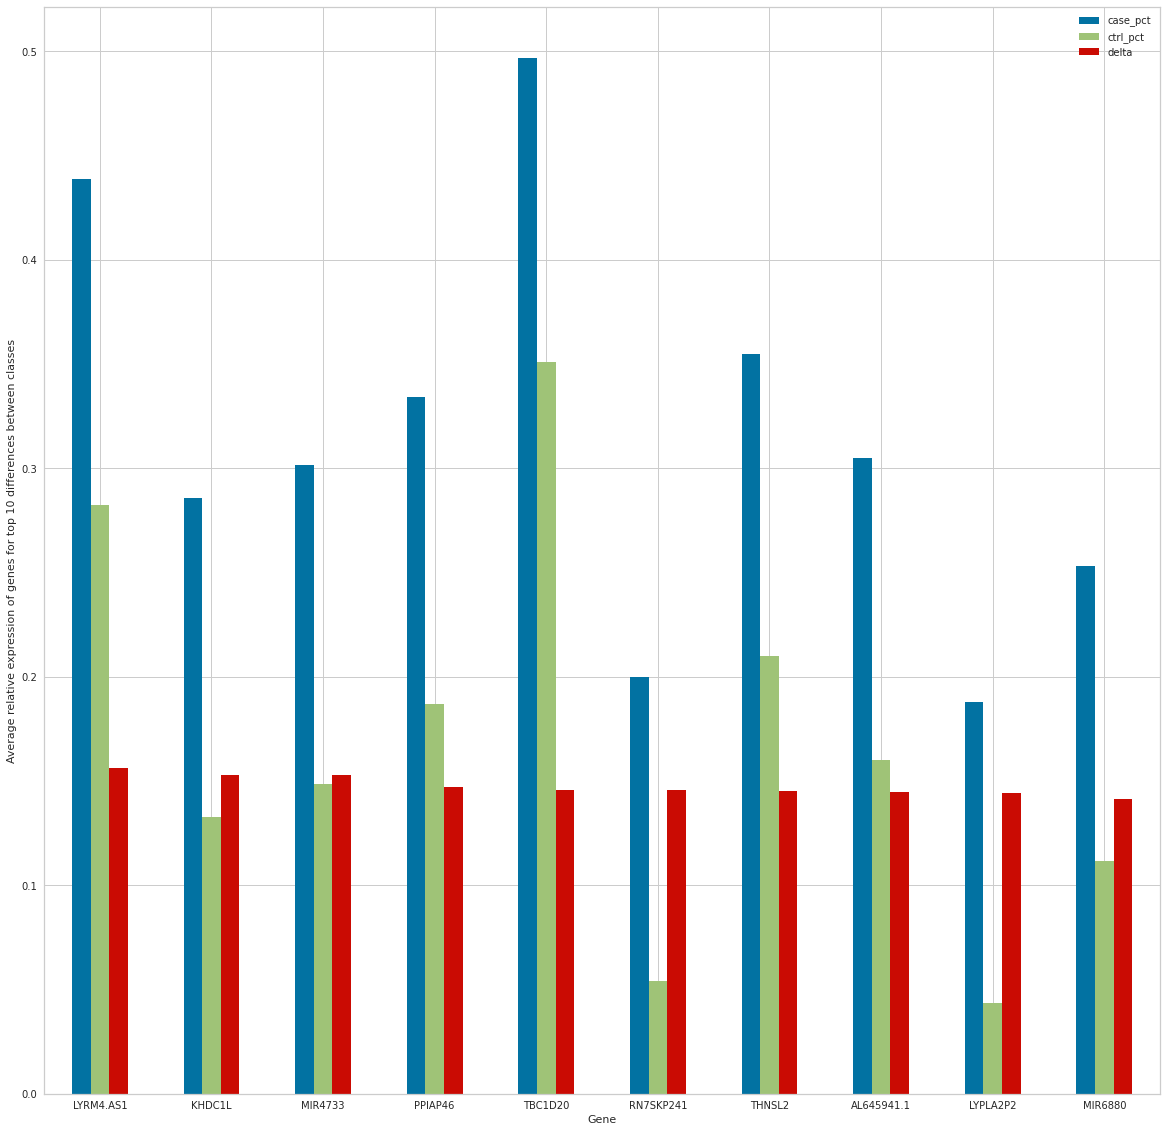

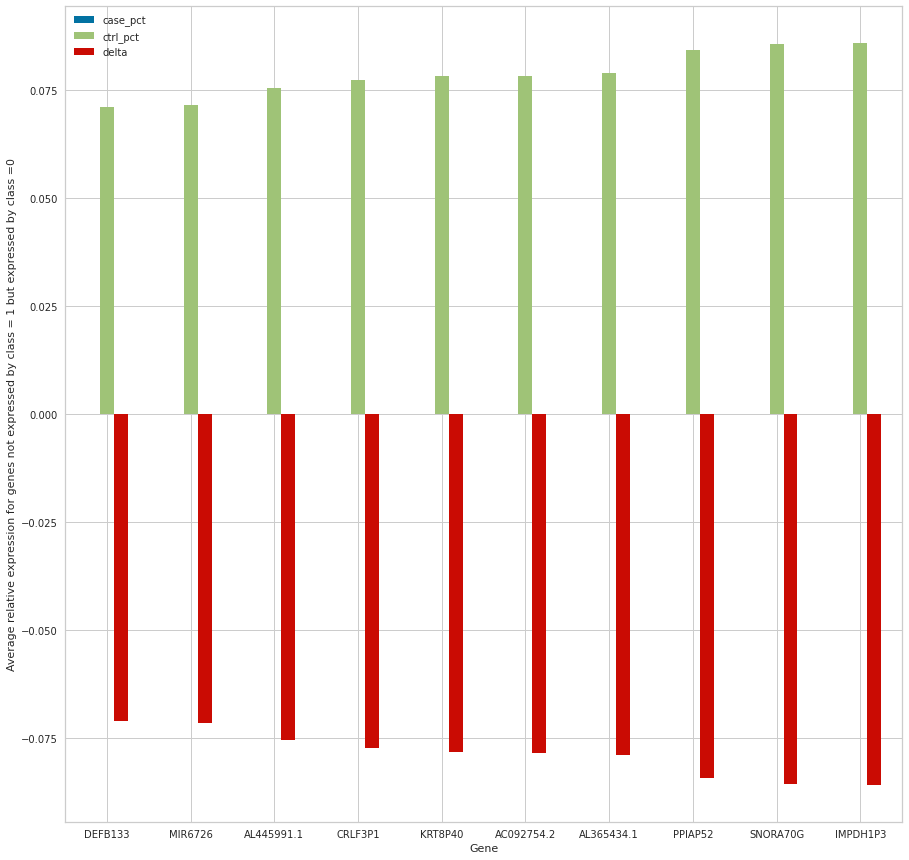

In [8]:
#step 2a - run the random forest classifier
df_BulbarvsLimb = pd.read_csv('/kaggle/input/end-als/end-als/transcriptomics-data/DESeq2/bulbar_vs_limb.csv')
df_BulbarvsLimb_temp = pd.merge(df_BulbarvsLimb,df_geno_bin,on='Participant_ID',how='inner')
Random_Forest_Classifier(dataset=df_BulbarvsLimb_temp,do_SMOTE=True,feature_idx=2,label_idx=1,ntrees=1000)

#step 2b - run the pseudo-gwas
df_label = df_BulbarvsLimb[['Participant_ID','SiteOnset_Class']]
df_genome_wide = pd.merge(df_label, df_geno_bin, on='Participant_ID', how='inner')
pseudo_genome_wide(dataset=df_genome_wide,label_name = 'SiteOnset_Class',feature_idx = 2)

#step 2b - run the rna comparison function
genome_wide_rna(dataset=df_BulbarvsLimb,label_name = 'SiteOnset_Class',feature_idx = 2)

mean rapid onset score is  0.022797557652502656


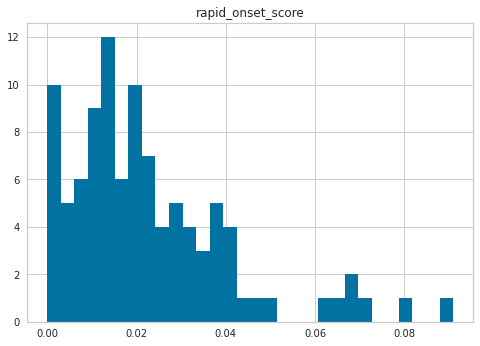

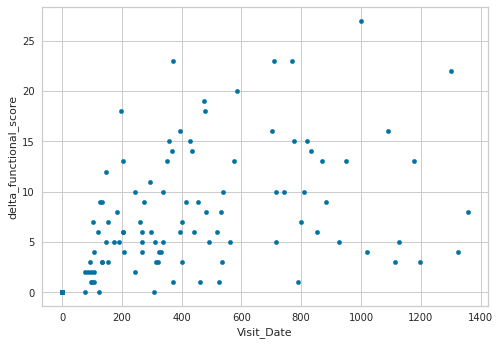

In [9]:
###create one dataset for random forest#####
#load the clinical data into memory and create a sum column for frs scores
df_alsfrs_r = pd.read_csv("/kaggle/input/end-als/end-als/clinical-data/filtered-metadata/metadata/clinical/ALSFRS_R.csv")
df_alsfrs_r['functional_sum']  = df_alsfrs_r['alsfrs1']+df_alsfrs_r['alsfrs2']+df_alsfrs_r['alsfrs3']+df_alsfrs_r['alsfrs4']+df_alsfrs_r['alsfrs5']+df_alsfrs_r['alsfrs6']+df_alsfrs_r['alsfrs7']+df_alsfrs_r['alsfrs8']+df_alsfrs_r['alsfrs9']

#there are multiple rows for each patient, so calculate the maximum frs score change and date and use that for the unique participant row
df_alsfrs_r_summary = df_alsfrs_r[['SubjectUID','Visit_Date','functional_sum']]
df_min = df_alsfrs_r_summary.groupby(by=['SubjectUID'],as_index=False)['functional_sum'].min()
df_min_date = df_alsfrs_r_summary.merge(df_min, on=['SubjectUID','functional_sum'],how='inner')
df_min_date['min_functional_sum'] = df_min_date['functional_sum']
df_min_date = df_min_date.drop(columns='functional_sum')
df_initial = df_alsfrs_r_summary[df_alsfrs_r_summary['Visit_Date']==0]
df_initial['initial_functional_sum']  = df_initial['functional_sum']
df_initial =df_initial.drop(columns = ['functional_sum','Visit_Date'])

df_alsfrs_r_data = pd.merge(df_initial, df_min_date, on='SubjectUID',how='inner')

#drop multiple subjectIDs where score didn't change between visits
df_alsfrs_r_data  = df_alsfrs_r_data.drop_duplicates(['SubjectUID', 'min_functional_sum'])
df_alsfrs_r_data['delta_functional_score'] = df_alsfrs_r_data['initial_functional_sum'] - df_alsfrs_r_data['min_functional_sum']

#calculate a score for how rapidly frs changes
df_alsfrs_r_data['rapid_onset_score'] = df_alsfrs_r_data['delta_functional_score'] / df_alsfrs_r_data['Visit_Date']

#plot the data
df_alsfrs_r_data.hist(column='rapid_onset_score',bins=30)
df_alsfrs_r_data.plot(kind='scatter',x='Visit_Date',y='delta_functional_score')
print('mean rapid onset score is ', np.mean(df_alsfrs_r_data['rapid_onset_score']))
df_alsfrs_r_data['rapid_onset_class'] = np.where(df_alsfrs_r_data['rapid_onset_score'] >= np.mean(df_alsfrs_r_data['rapid_onset_score']), 1, 0)
df_alsfrs_r_data = df_alsfrs_r_data.rename(columns = {'SubjectUID':'Participant_ID'})


df_alsfrs_r_data = df_alsfrs_r_data.rename(columns = {'SubjectUID':'Participant_ID'})
df_rna_onset = pd.merge(df_alsfrs_r_data,df_ctrlvscase, on='Participant_ID',how='inner')

###test a second approach where I create a cohort for long term and short term survival (frs score loss)
###create cohort with long term survival
df_alsfrs_r_ltsurvival = df_alsfrs_r_data[(df_alsfrs_r_data['delta_functional_score']<5)&(df_alsfrs_r_data['Visit_Date']>(365*2))]
df_alsfrs_r_ltsurvival['survival_prospect'] = 1

#create cohort with short term survival
df_alsfrs_r_stsurvival = df_alsfrs_r_data[(df_alsfrs_r_data['delta_functional_score']>10)&(df_alsfrs_r_data['Visit_Date']<(365*1))]
df_alsfrs_r_stsurvival['survival_prospect'] = 0

#stack dataframes and create new classification column for short or long term survival
df_survival = pd.concat([df_alsfrs_r_ltsurvival,df_alsfrs_r_stsurvival])
df_survival = df_survival.rename(columns = {'SubjectUID':'Participant_ID'})

#join to transcriptomics data
df_survival_rna = pd.merge(df_survival,df_ctrlvscase, on='Participant_ID',how='inner')

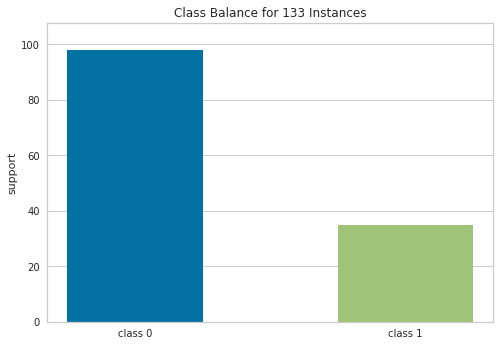

oversampled shape of X is  (196, 53859)
oversampled shape of y is  (196,) 

reduced dimension of training input from  (156, 53859) to  (156, 9015) by dropping irrelevant features 



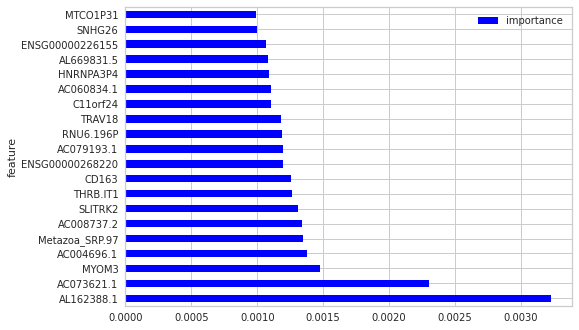

Check that the output prediction is not simply returning a trivial solution of all 1s 
 [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0] 

Simple accuracy is: 95.00% 

ROC AUC is  0.9523809523809523 



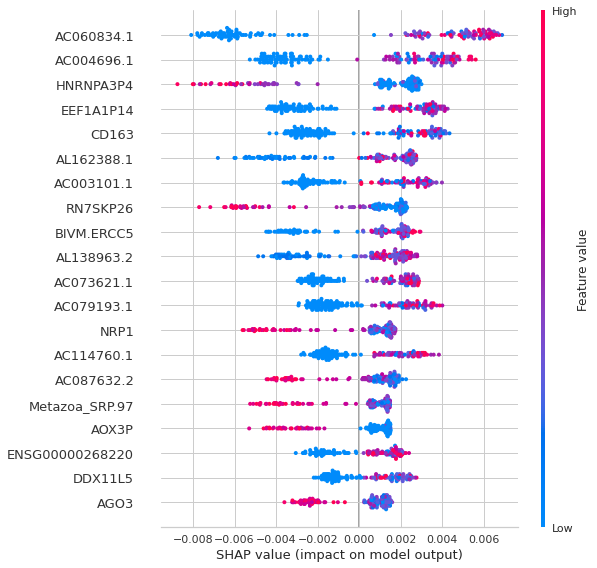

In [10]:
Random_Forest_Classifier(dataset=df_rna_onset,do_SMOTE=True,feature_idx=8,label_idx=6,ntrees=1000)

In [11]:
###try to rank features on the tiny dataset with extreme examples of rapid onset vs delayed frs score loss
from sklearn.ensemble import ExtraTreesClassifier

# define dataset
X, y = df_survival_rna.iloc[:,8:],df_survival_rna.iloc[:,6]

#save the feature names for later
feature_names = X.columns.tolist()

#https://www.kaggle.com/rafjaa/dealing-with-very-small-datasets
TOP_FEATURES = 5

forest = ExtraTreesClassifier(n_estimators=1000, max_depth=5, random_state=1)
forest.fit(X, y)

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]

print('Top features:')
for f in range(TOP_FEATURES):
    print(f + 1, feature_names[indices[f]], importances[indices[f]])

Top features:
1 C8orf86 0.0062658730158730155
2 AC008764.4 0.003607142857142858
3 FMC1.LUC7L2 0.003428571428571429
4 BHLHA9 0.003428571428571429
5 AC108039.1 0.003428571428571429


In [12]:
def plot_feature_importances(df):
    '''
    Adapted from https://github.com/WillKoehrsen/feature-selector
    '''
    #Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    #Normalise the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    #Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10,6))
    ax = plt.subplot()
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    #Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    #Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importance')
    plt.show()
    return df

In [13]:
demographics = pd.read_csv('/kaggle/input/end-als/end-als/clinical-data/filtered-metadata/metadata/clinical/Demographics.csv')
alsfrs_scores = pd.read_csv('/kaggle/input/end-als/end-als/clinical-data/filtered-metadata/metadata/clinical/ALSFRS_R.csv')
bulbar_vs_limb = pd.read_csv('/kaggle/input/end-als/end-als/transcriptomics-data/DESeq2/bulbar_vs_limb.csv')
ctrl_vs_case = pd.read_csv('/kaggle/input/end-als/end-als/transcriptomics-data/DESeq2/ctrl_vs_case.csv')

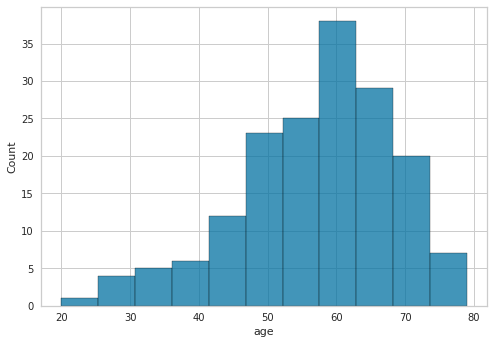

In [14]:
import seaborn as sns
sns.histplot(demographics.age);

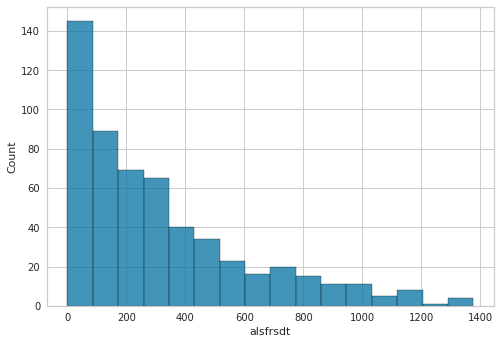

In [15]:
sns.histplot(alsfrs_scores.alsfrsdt);

In [16]:
rows = 1000 # specify 'None' if want to read whole file
df_genes = pd.read_csv('../input/cusersmarildownloadsgenescsv/genes.csv', delimiter=';', encoding = "ISO-8859-2", nrows = rows)
df_genes.dataframeName = 'genes.csv'
nRow, nCol = df_genes.shape
print(f'There are {nRow} rows and {nCol} columns')
df_genes.head()

There are 40 rows and 4 columns


,Gene,Associated_ND,Phenotype_influence,Key_reference
0,ANG,ALS/PD,Â,-21
1,ANXA11,ALS,Â,-22
2,APOE,Â,Longer survival,-23
3,ATXN2,ALS,Â,-24
4,CAMTA1,Â,Shorter survival,-25


In [17]:
df_genes["Gene"].value_counts()

EPHA4              1
TAF15              1
TUBA4A             1
FIG4               1
CAMTA1             1
ANXA11             1
NEK1               1
CHCHD10            1
MOBP               1
OPTN               1
SARM1              1
SETX               1
1p34- rs3011225    1
PFN1               1
ATXN2              1
IDE                1
MATR3              1
PGRN               1
VAPB               1
VCP                1
TARDBP             1
NIPA1              1
KIF5A              1
SQSTM1             1
SCFD1              1
SOD1               1
SPG11              1
TBK1               1
DCTN1              1
ANG                1
8p23.2             1
CCNF               1
UBQLN2             1
APOE               1
DAO                1
C21orf2            1
C9orf72            1
FUS                1
HNRNPA1            1
UNC13A             1
Name: Gene, dtype: int64

In [18]:
df_genes["Associated_ND"].value_counts()

ALS        24
FTD/ALS    10
Â           5
ALS/PD      1
Name: Associated_ND, dtype: int64

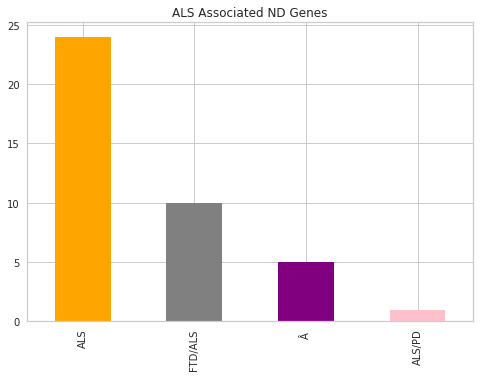

In [19]:
df_genes["Associated_ND"].value_counts().plot.bar(color=['orange', 'grey','purple','pink'], title='ALS Associated ND Genes');

In [20]:
df_genes["Phenotype_influence"].value_counts()

Â                                                      30
Shorter survival                                        3
Longer survival                                         2
Late age of onset                                       1
Limb-onset, early age of onset and shorter survival     1
Primarily bulbar onset                                  1
Early age of onset and shorter survival                 1
Limb-onset                                              1
Name: Phenotype_influence, dtype: int64

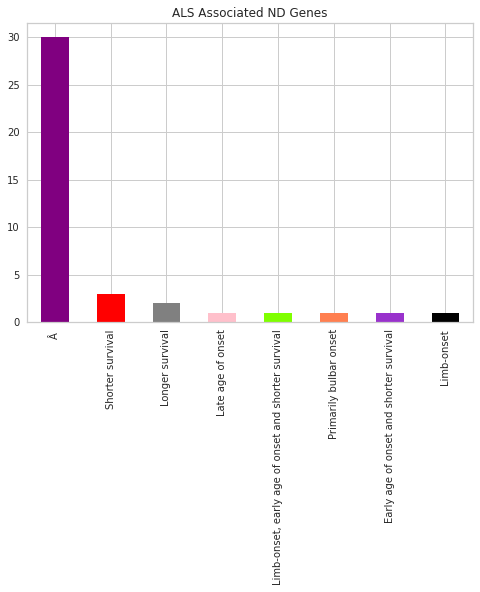

In [21]:
df_genes["Phenotype_influence"].value_counts().plot.bar(color=['purple', 'red','grey','pink', 'Chartreuse', 'Coral', 'DarkOrchid', 'black'], title='ALS Associated ND Genes');

In [22]:
long_survival = df_genes[(df_genes['Phenotype_influence']=='Longer survival')]
long_survival.head()

,Gene,Associated_ND,Phenotype_influence,Key_reference
2,APOE,Â,Longer survival,-23
11,EPHA4,Â,Longer survival,-31


In [23]:
short_survival = df_genes[(df_genes['Phenotype_influence']=='Shorter survival')].reset_index(drop=True)
short_survival.head()

,Gene,Associated_ND,Phenotype_influence,Key_reference
0,CAMTA1,Â,Shorter survival,-25
1,IDE,Â,Shorter survival,-25
2,UNC13A,ALS,Shorter survival,-26


In [24]:
phenotype = df_genes[(df_genes['Phenotype_influence']=='Limb-onset, early age of onset and shorter survival')].reset_index(drop=True)
phenotype.head()

,Gene,Associated_ND,Phenotype_influence,Key_reference
0,SOD1,ALS,"Limb-onset, early age of onset and shorter sur...",-41


In [25]:
# Protein protein interactions data
df_protein = '/kaggle/input/pro-bio/Protein-Biogrid.csv'
df = pd.read_csv(df_protein)
df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,Throughput,Source Database,SWISS-PROT Accessions Interactor A,TREMBL Accessions Interactor A,REFSEQ Accessions Interactor A,SWISS-PROT Accessions Interactor B,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Low Throughput,BIOGRID,P45985,-,NP_003001|NP_001268364,Q14315,Q59H94,NP_001120959|NP_001449,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Low Throughput,BIOGRID,Q86TC9,A0A087WX60,NP_001243197|NP_001243196|NP_115967,P35609,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,Low Throughput,BIOGRID,Q04771,D3DPA4,NP_001104537|NP_001096,P49354,-,NP_002018,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,Low Throughput,BIOGRID,P23769,-,NP_001139134|NP_116027|NP_001139133,P29590,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,Low Throughput,BIOGRID,P15927,B4DUL2,NP_001342057|NP_002937|NP_001284487|NP_0013420...,P40763,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,Homo sapiens,Homo sapiens


In [26]:
df_genes_ALSoD = pd.read_csv('/kaggle/input/proteinproteininteraction/genes_from_alsod.csv')
genes_ALS = list( df_genes_ALSoD['Gene symbol'])

In [27]:
A = df['Official Symbol Interactor A'].isin(genes_ALS) & (df['Organism Name Interactor A'] == 'Homo sapiens') & (df['Organism Name Interactor B'] == 'Homo sapiens')
B = df['Official Symbol Interactor B'].isin(genes_ALS) & (df['Organism Name Interactor A'] == 'Homo sapiens') & (df['Organism Name Interactor B'] == 'Homo sapiens')
data1 =  df[A]['Official Symbol Interactor B'].value_counts() 
data2 =  df[B]['Official Symbol Interactor A'].value_counts() 
d = data1.to_frame().join(data2, how = 'outer')
dataset_protein = d.fillna(0)
dataset_protein['Count All Interactions'] = dataset_protein.iloc[:,0] + dataset_protein.iloc[:,1]
d = dataset_protein.join( df_genes_ALSoD.set_index('Gene symbol') )
d = d.sort_values('Count All Interactions',ascending = False)
d = d[['Count All Interactions', 'Gene name', 'Category' , 'Official Symbol Interactor A', 'Official Symbol Interactor B'] ]
d.columns = ['Count All BIOGRID Interactions', 'Gene name', 'Relation to ALS' , 'Count Left Interactions', 'Count Right Interactions']  

print(d.columns)
d.index.name = 'Gene symbol'
d.dropna(axis=0,inplace=True)
d

Index(['Count All BIOGRID Interactions', 'Gene name', 'Relation to ALS',
       'Count Left Interactions', 'Count Right Interactions'],
      dtype='object')


,Count All BIOGRID Interactions,Gene name,Relation to ALS,Count Left Interactions,Count Right Interactions
Gene symbol,,,,,
UBQLN1,2.0,ubiquilin 1,Tenuous,1.0,1.0
SMN1,2.0,"survival of motor neuron 1, telomeric",Moderate evidence,1.0,1.0
SYNE1,2.0,spectrin repeat containing nuclear envelope pr...,Tenuous,1.0,1.0
SOD1,1.0,superoxide dismutase 1,Definitive ALS gene,0.0,1.0
AGT,1.0,angiotensinogen,Tenuous,1.0,0.0


Lower SOD1 expression levels were found for limb onset with p value  0.9585327729330135


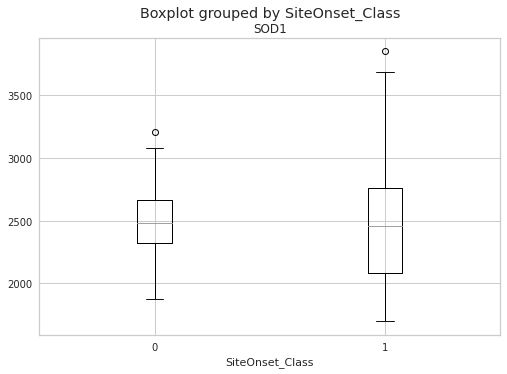

In [28]:
from scipy import stats
df_BulbarvsLimb = pd.read_csv('/kaggle/input/end-als/end-als/transcriptomics-data/DESeq2/bulbar_vs_limb.csv')
df_BulbarvsLimb.boxplot(column=['SOD1'],by='SiteOnset_Class')

groupA = df_BulbarvsLimb.where(df_BulbarvsLimb.SiteOnset_Class== 0).dropna()['SOD1']
groupB = df_BulbarvsLimb.where(df_BulbarvsLimb.SiteOnset_Class== 1).dropna()['SOD1']

print('Lower SOD1 expression levels were found for limb onset with p value ', stats.ttest_ind(groupA,groupB)[1])

{0: 'Bulbar', 1: 'Limb'}


Text(0.5, 0.98, 'SOD1 counts vs Diagnosis (0 = Bulbar; 1 = Limb)')

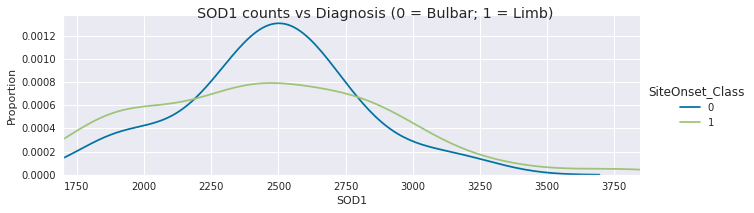

In [29]:
dict_characters = {0: 'Bulbar', 1: 'Limb'} # double check this
print(dict_characters)
sns.set_style("darkgrid")
plt = sns.FacetGrid(bulbar_vs_limb, hue='SiteOnset_Class',aspect=3)
plt.map(sns.kdeplot,'SOD1',shade=False)
plt.set(xlim=(bulbar_vs_limb['SOD1'].min(), bulbar_vs_limb['SOD1'].max()))
plt.add_legend()
plt.set_axis_labels('SOD1', 'Proportion')
plt.fig.suptitle('SOD1 counts vs Diagnosis (0 = Bulbar; 1 = Limb)')